In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from math import inf
from scipy.spatial import distance, ConvexHull
from scipy.spatial.qhull import QhullError
from scipy.stats import ttest_ind, kstest, mannwhitneyu, ranksums, kruskal

In [83]:
cm_conversion = 100 / 49.624 # trex sets px to cm as 100 (3.000 pixel width, 30 cm width as default)

age_to_be_analysed = 28 # change to 28 if you need to
time = np.linspace(0,30,1799)

if age_to_be_analysed == 56:
    analysis_df = pd.read_pickle('C:\\Users\\gemmera\\Anaconda3\\OWNscripts\\TRex_analysis_56dpf.pkl') # change to corresponding path
    analysis_df = pd.DataFrame.from_dict({(i,j): analysis_df[i][j]
                           for i in analysis_df.keys()
                           for j in analysis_df[i].keys()},
                       orient='index')
    levelList = [list for list in analysis_df.index[[0]].levels]
    levelList[0] = ['oxtrl KO' , 'oxtrl WT' , 'oxtr KO' , 'oxtr WT' , '$pth2^{-/-}$' , '$pth2^{+/+}$']

    
elif age_to_be_analysed == 28:
    analysis_df = pd.read_pickle('C:\\Users\\gemmera\\Anaconda3\\OWNscripts\\TRex_analysis_28dpf.pkl')
    analysis_df = pd.DataFrame.from_dict({(i,j): analysis_df[i][j]
                           for i in analysis_df.keys()
                           for j in analysis_df[i].keys()},
                       orient='index')
    levelList = [list for list in analysis_df.index[[0]].levels]
    levelList[0] = ['oxtrl KO' , 'oxtrl WT' , 'oxtr KO' , 'oxtr WT']

analysis_df.index.set_levels(levelList, inplace = True)
genotypes = analysis_df.index[[0]].levels[0] #save the different genotypes analysed in a separate array to loop through

# create velocity sub-dataset
vel_df = analysis_df['velocity'].apply(pd.Series).transpose()
#a = vel_df['ILR1K']['15'][2] # replace all 'inf' with nan
a = inf
vel_df.replace(a, np.nan, inplace=True)


vel_df = vel_df/(30*cm_conversion) # in the TRex_analysis script, I initially summed up over 30 frames, believing velocity was returned as px/frame. 
vel_med_df = vel_df.median(skipna=True)

# create nearest-neighbor sub-dataset and convert to cm
NND_df = analysis_df['nearestneighbor'].apply(pd.Series).transpose()
NND_df = NND_df/cm_conversion
NND_med_df = NND_df.median(skipna=True)

# create Median distance sub-dataset and convert to cm
dist_df = analysis_df['neighbor'].apply(pd.Series).transpose()
dist_df = dist_df/cm_conversion
dist_med_df = dist_df.median(skipna=True)

# create farthest-neighbor sub-dataset and convert to cm
FD_df = analysis_df['neighbor_max'].apply(pd.Series).transpose()
FD_df = FD_df/cm_conversion
FD_med_df = FD_df.median(skipna=True)

In [4]:
#nn_df = pd.melt(pd.DataFrame(analysis_df['nearestneighbor'].apply(pd.Series).transpose().median()/cm_conversion).transpose()).iloc[:,[0,2]]
#nn_df.columns = ['genotype' , 'values']
#nn_df['feature'] = pd.Series(np.repeat('nearest neighbor' , len(nn_df)))

#mediandist_df = pd.melt(pd.DataFrame(analysis_df['neighbor'].apply(pd.Series).transpose().median()/cm_conversion).transpose()).iloc[:,[0,2]]
#mediandist_df.columns = ['genotype' , 'values']
#mediandist_df['feature'] = pd.Series(np.repeat('median distance' , len(mediandist_df)))

#maxdist_df = pd.melt(pd.DataFrame(analysis_df['neighbor_max'].apply(pd.Series).transpose().median()/cm_conversion).transpose()).iloc[:,[0,2]]
#maxdist_df.columns = ['genotype' , 'values']
#maxdist_df['feature'] = pd.Series(np.repeat('maximum distance' , len(maxdist_df)))

# ILR2: Differences in velocity over time

The median velocity over time (bodylength/second) is plotted. For the individual videos, the median is computed from individual animals and for the depiction here, the median is computed from all the individual videos.

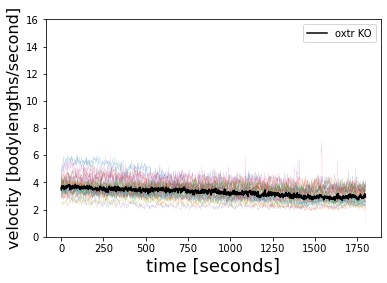

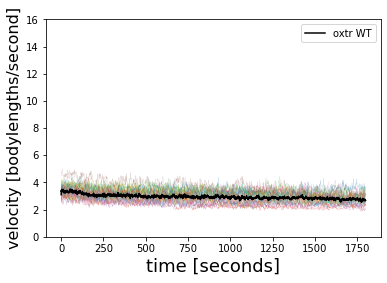

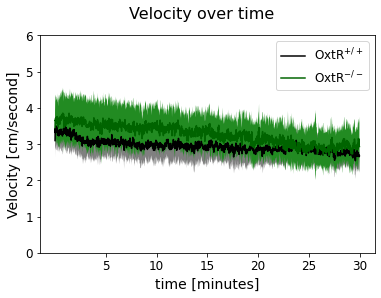

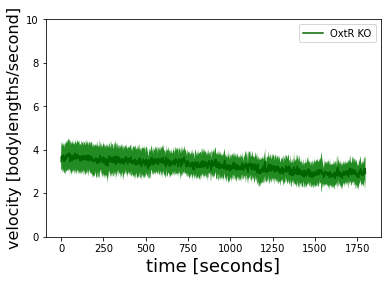

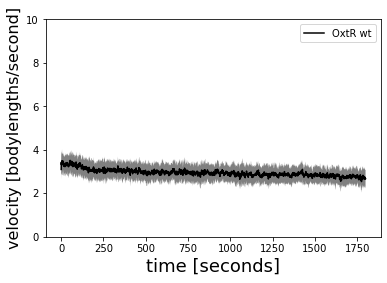

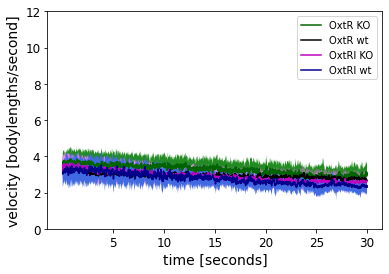

In [5]:
time = np.linspace(0,1799,1799) # velocity was subsampled to 1 Hz.

def plot_over_time(genotype):
    fig = plt.figure()
    time = np.linspace(0,1799,1799)
    plt.plot(time, vel_df[genotype], linewidth = 0.1)
    plt.plot(time, vel_df[genotype].median(axis = 1), 'k', label = genotype)
    plt.xlabel('time [seconds]', fontsize=18)
    plt.ylabel('velocity [bodylengths/second]', fontsize=16)
    plt.ylim(0, 16)
    plt.legend()
    
plot_over_time('oxtr KO')
plot_over_time('oxtr WT')


fig = plt.figure()
time = np.linspace(0,1799,1799)

plt.plot(time, vel_df['oxtr WT'].median(axis = 1),'k', label='$\mathregular{OxtR^{+/+}}$')
plt.fill_between(time, vel_df['oxtr WT'].median(axis = 1) - vel_df['oxtr WT'].std(axis = 1),
         vel_df['oxtr WT'].median(axis = 1) + vel_df['oxtr WT'].std(axis = 1), fc = 'grey')
plt.plot(time, vel_df['oxtr KO'].median(axis = 1),'darkgreen', label='$\mathregular{OxtR^{-/-}}$')
plt.fill_between(time, vel_df['oxtr KO'].median(axis = 1) - vel_df['oxtr KO'].std(axis = 1),
         vel_df['oxtr KO'].median(axis = 1) + vel_df['oxtr KO'].std(axis = 1), fc = 'forestgreen')
plt.xlabel('time [seconds]', fontsize=18)
#plt.plot(time, vel_df['oxtrl KO'].median(axis = 1),'m', label='oxtrl KO')
#plt.plot(time, vel_df['oxtrl WT'].median(axis = 1),'k', label='oxtrl WT')
fig.suptitle('Velocity over time', fontsize=16)
plt.xlabel('time [minutes]', fontsize=14)
plt.xticks(ticks=(300, 600, 900, 1200, 1500, 1800), labels=('5', '10', '15', '20', '25', '30'), fontsize=12, 
           rotation=0)
plt.ylabel('Velocity [cm/second]', fontsize=14)
plt.yticks(ticks=(0,1,2,3,4,5,6), labels=('0', '1', '2', '3', '4', '5', '6'), fontsize=12, 
           rotation=0)
plt.ylim(0, 6)
plt.legend(loc = 'upper right', fontsize=12)

fig = plt.figure()
time = np.linspace(0,1799,1799)
plt.plot(time, vel_df['oxtr KO'].median(axis = 1),'darkgreen', label='OxtR KO')
plt.fill_between(time, vel_df['oxtr KO'].median(axis = 1) - vel_df['oxtr KO'].std(axis = 1),
         vel_df['oxtr KO'].median(axis = 1) + vel_df['oxtr KO'].std(axis = 1), fc = 'forestgreen')
#plt.plot(time, vel_df['oxtr WT'].median(axis = 1),'k', label='OxtR wt')
#plt.plot(time, vel_df['oxtrl KO'].median(axis = 1),'m', label='oxtrl KO')
#plt.plot(time, vel_df['oxtrl WT'].median(axis = 1),'k', label='oxtrl WT')
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('velocity [bodylengths/second]', fontsize=16)
plt.ylim(0, 10)
plt.legend()

fig = plt.figure()
time = np.linspace(0,1799,1799)
#plt.plot(time, vel_df['oxtr KO'].median(axis = 1),'darkgreen', label='OxtR KO')
plt.plot(time, vel_df['oxtr WT'].median(axis = 1),'k', label='OxtR wt')
plt.fill_between(time, vel_df['oxtr WT'].median(axis = 1) - vel_df['oxtr WT'].std(axis = 1),
         vel_df['oxtr WT'].median(axis = 1) + vel_df['oxtr WT'].std(axis = 1), fc = 'grey')
#plt.plot(time, vel_df['oxtrl KO'].median(axis = 1),'m', label='oxtrl KO')
#plt.plot(time, vel_df['oxtrl WT'].median(axis = 1),'k', label='oxtrl WT')
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('velocity [bodylengths/second]', fontsize=16)
plt.ylim(0, 10)
plt.legend()

fig = plt.figure()
time = np.linspace(0,1799,1799)
plt.plot(time, vel_df['oxtr KO'].median(axis = 1),'darkgreen', label='OxtR KO')
plt.fill_between(time, vel_df['oxtr KO'].median(axis = 1) - vel_df['oxtr KO'].std(axis = 1),
         vel_df['oxtr KO'].median(axis = 1) + vel_df['oxtr KO'].std(axis = 1), fc = 'forestgreen')
plt.xlabel('time [seconds]', fontsize=18)
plt.plot(time, vel_df['oxtr WT'].median(axis = 1),'k', label='OxtR wt')
plt.fill_between(time, vel_df['oxtr WT'].median(axis = 1) - vel_df['oxtr WT'].std(axis = 1),
         vel_df['oxtr WT'].median(axis = 1) + vel_df['oxtr WT'].std(axis = 1), fc = 'grey')
plt.plot(time, vel_df['oxtrl KO'].median(axis = 1),'m', label='OxtRl KO')
plt.fill_between(time, vel_df['oxtrl KO'].median(axis = 1) - vel_df['oxtrl KO'].std(axis = 1),
         vel_df['oxtrl KO'].median(axis = 1) + vel_df['oxtrl KO'].std(axis = 1), fc = 'violet')
#plt.plot(time, vel_df['oxtrl WT'].median(axis = 1),'darkblue', label='OxtRl wt')
plt.plot(time, vel_df['oxtrl WT'].median(axis = 1),'darkblue', label='OxtRl wt')
plt.fill_between(time, vel_df['oxtrl WT'].median(axis = 1) - vel_df['oxtrl WT'].std(axis = 1),
         vel_df['oxtrl WT'].median(axis = 1) + vel_df['oxtrl WT'].std(axis = 1), fc = 'royalblue')
#plt.plot(time, vel_df['oxtrl KO'].median(axis = 1),'m', label='oxtrl KO')
#plt.plot(time, vel_df['oxtrl WT'].median(axis = 1),'k', label='oxtrl WT')
plt.xlabel('time [seconds]', fontsize=14)
plt.ylabel('velocity [bodylengths/second]', fontsize=14)
plt.xticks(ticks=(300, 600, 900, 1200, 1500, 1800), labels=('5', '10', '15', '20', '25', '30'), fontsize=12, 
           rotation=0)
plt.ylim(4, 12)
plt.yticks(ticks=(0,2,4,6,8,10,12), labels=('0', '2', '4', '6', '8', '10', '12'), fontsize=12, 
           rotation=0)
plt.legend()

Text(0, 0.5, 'velocity [cm/seconds]')

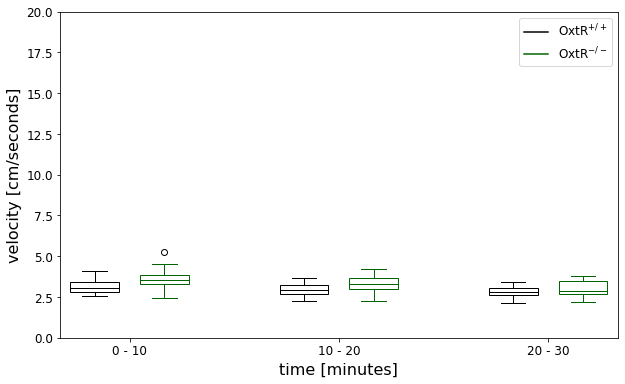

In [6]:
ind = list(range(0,len(vel_df), 600))
vel_df_minute = vel_df.iloc[0:3].copy()
for i in range(1,len(ind)):
    av = vel_df.iloc[ind[i-1]:ind[i]].median(skipna=True)
    vel_df_minute.iloc[i-1] = av
    if i == len(ind)-1:
        av = vel_df.iloc[ind[i]:].median(skipna=True)
        vel_df_minute.iloc[i] = av

fig, ax = plt.subplots(figsize = (10,6))        
plt.boxplot(vel_df_minute['oxtr KO'].transpose(), widths = 0.7, positions=[1,4,7], patch_artist=True, 
            boxprops=dict(facecolor='white',color='darkgreen'), whiskerprops=dict(color='darkgreen'), 
            capprops=dict(color='darkgreen'), medianprops=dict(color='darkgreen'), flierprops=dict(color='darkgreen'))
plt.boxplot(vel_df_minute['oxtr WT'].transpose(), widths = 0.7, positions=[0,3,6], patch_artist=True,
            boxprops=dict(facecolor='white',color='black'), whiskerprops=dict(color='black'), 
            capprops=dict(color='black'), medianprops=dict(color='black'), flierprops=dict(color='black'))

plt.plot([], c='black', label='$\mathregular{OxtR^{+/+}}$')
plt.plot([], c='darkgreen', label='$\mathregular{OxtR^{-/-}}$')
plt.legend(fontsize = 12)

ax.set(ylim = (0,20))
plt.xticks(ticks=(0.5, 3.5, 6.5), labels=('0 - 10', '10 - 20', '20 - 30'), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('time [minutes]', fontsize = 16)
plt.ylabel('velocity [cm/seconds]', fontsize = 16)

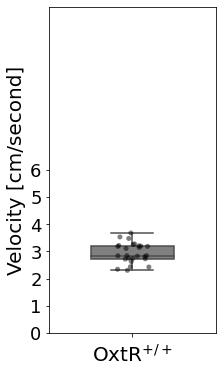

In [7]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=vel_med_df['oxtr WT'], width = 0.5, color='grey')
bplot = sns.stripplot(y=vel_med_df['oxtr WT'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Velocity [cm/second]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtR^{+/+}}$', fontsize = 20)
bplot.set_ylim(0,12)
bplot.set_yticks(ticks=(0,1,2,3,4,5,6))
bplot.tick_params(labelsize = 18)

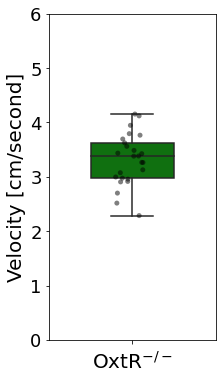

In [8]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=vel_med_df['oxtr KO'], width = 0.5, color='green')
bplot = sns.stripplot(y=vel_med_df['oxtr KO'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Velocity [cm/second]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtR^{-/-}}$', fontsize = 20)
bplot.set_ylim(0,6)
bplot.set_yticks(ticks=(0,1,2,3,4,5,6))
bplot.tick_params(labelsize = 18)

Text(0, 0.5, 'Median velocity [cm/second]')

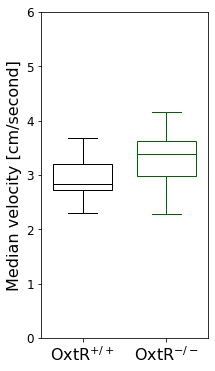

In [9]:
#vel_df.dropna(inplace=True, axis=0) # removes all NaN, needed for 56dpf 

fig, ax = plt.subplots(figsize = (3,6))        
plt.boxplot(vel_med_df['oxtr KO'].transpose(), positions=[1], widths = 0.7, patch_artist=True, 
            boxprops=dict(facecolor='white',color='darkgreen'), whiskerprops=dict(color='darkgreen'), 
            capprops=dict(color='darkgreen'), medianprops=dict(color='darkgreen'), flierprops=dict(color='darkgreen'))
plt.boxplot(vel_med_df['oxtr WT'].transpose(), positions=[0], widths = 0.7, patch_artist=True,
            boxprops=dict(facecolor='white',color='black'), whiskerprops=dict(color='black'), 
            capprops=dict(color='black'), medianprops=dict(color='black'), flierprops=dict(color='black'))



ax.set(ylim = (0,6))
plt.xticks(ticks=(0, 1), labels=('$\mathregular{OxtR^{+/+}}$', '$\mathregular{OxtR^{-/-}}$',), fontsize=16, 
           rotation=0)
plt.yticks(fontsize=12)
plt.ylabel('Median velocity [cm/second]', fontsize = 16)

# ILR1: Differences in velocity over time

The median velocity over time (bodylength/second) is plotted. For the individual videos, the median is computed from individual animals and for the depiction here, the median is computed from all the individual videos.

(4.0, 12.0)

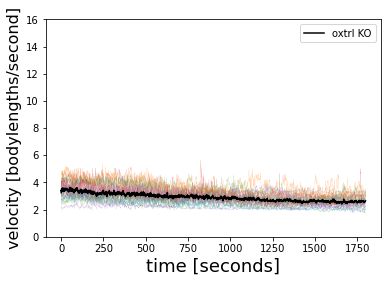

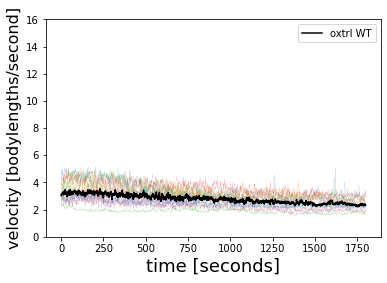

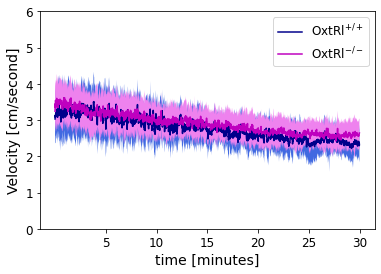

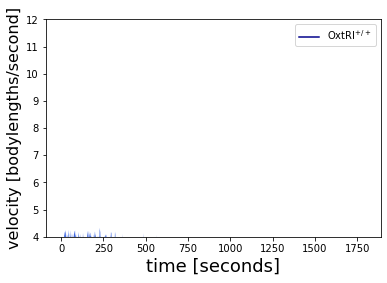

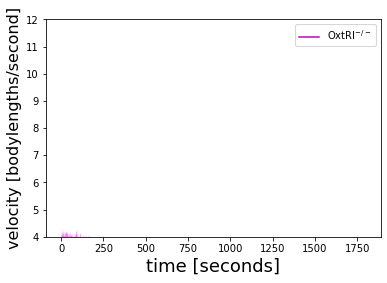

In [10]:
plot_over_time('oxtrl KO')
plot_over_time('oxtrl WT')


fig = plt.figure()
plt.plot(time, vel_df['oxtrl WT'].median(axis = 1),'darkblue', label='$\mathregular{OxtRl^{+/+}}$')
plt.fill_between(time, vel_df['oxtrl WT'].median(axis = 1) - vel_df['oxtrl WT'].std(axis = 1),
         vel_df['oxtrl WT'].median(axis = 1) + vel_df['oxtrl WT'].std(axis = 1), fc = 'royalblue')
plt.plot(time, vel_df['oxtrl KO'].median(axis = 1),'m', label='$\mathregular{OxtRl^{-/-}}$')
plt.fill_between(time, vel_df['oxtrl KO'].median(axis = 1) - vel_df['oxtrl KO'].std(axis = 1),
         vel_df['oxtrl KO'].median(axis = 1) + vel_df['oxtrl KO'].std(axis = 1), fc = 'violet')
plt.xticks(ticks=(300, 600, 900, 1200, 1500, 1800), labels=('5', '10', '15', '20', '25', '30'), fontsize=12, 
           rotation=0)
plt.xlabel('time [minutes]', fontsize=14)
plt.ylabel('Velocity [cm/second]', fontsize=14)
plt.yticks(ticks=(0,1,2,3,4,5,6), labels=('0', '1', '2', '3', '4', '5', '6'), fontsize=12, 
           rotation=0)
plt.ylim(0, 6)
plt.legend(loc = 'upper right', fontsize=12)

#plt.plot(time, vel_df['oxtrl WT'].median(axis = 1),'darkblue', label='OxtRl wt')


fig = plt.figure()
#plt.plot(time, vel_df['oxtrl KO'].median(axis = 1),'m', label='OxtRl KO')
plt.plot(time, vel_df['oxtrl WT'].median(axis = 1),'darkblue', label='$\mathregular{OxtRl^{+/+}}$')
plt.fill_between(time, vel_df['oxtrl WT'].median(axis = 1) - vel_df['oxtrl WT'].std(axis = 1),
         vel_df['oxtrl WT'].median(axis = 1) + vel_df['oxtrl WT'].std(axis = 1), fc = 'royalblue')
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('velocity [bodylengths/second]', fontsize=16)
plt.legend()
plt.ylim(4, 12)

fig = plt.figure()
plt.plot(time, vel_df['oxtrl KO'].median(axis = 1),'m', label='$\mathregular{OxtRl^{-/-}}$')
plt.fill_between(time, vel_df['oxtrl KO'].median(axis = 1) - vel_df['oxtrl KO'].std(axis = 1),
         vel_df['oxtrl KO'].median(axis = 1) + vel_df['oxtrl KO'].std(axis = 1), fc = 'violet')
#plt.plot(time, vel_df['oxtrl WT'].median(axis = 1),'darkblue', label='OxtRl wt')
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('velocity [bodylengths/second]', fontsize=16)
plt.legend()
plt.ylim(4, 12)


Text(0, 0.5, 'velocity [cm/seconds]')

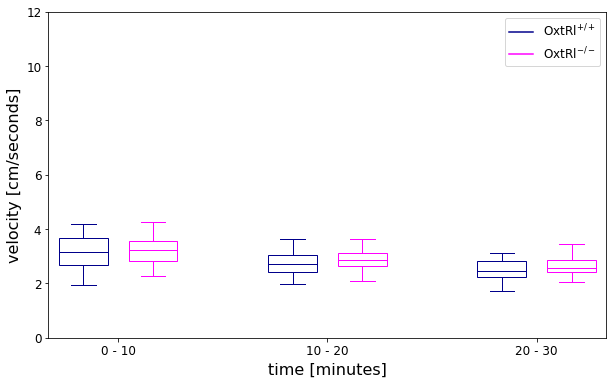

In [11]:
fig, ax = plt.subplots(figsize = (10,6))        
plt.boxplot(vel_df_minute['oxtrl KO'].transpose(), widths = 0.7, positions=[1,4,7], patch_artist=True, 
            boxprops=dict(facecolor='white',color='magenta'), whiskerprops=dict(color='magenta'), 
            capprops=dict(color='magenta'), medianprops=dict(color='magenta'), flierprops=dict(color='darkgreen'))
plt.boxplot(vel_df_minute['oxtrl WT'].transpose(), widths = 0.7, positions=[0,3,6], patch_artist=True,
            boxprops=dict(facecolor='white',color='darkblue'), whiskerprops=dict(color='darkblue'), 
            capprops=dict(color='darkblue'), medianprops=dict(color='darkblue'), flierprops=dict(color='black'))

plt.plot([], c='darkblue', label='$\mathregular{OxtRl^{+/+}}$')
plt.plot([], c='magenta', label='$\mathregular{OxtRl^{-/-}}$')
plt.legend(fontsize=12)

ax.set(ylim = (0,12))
plt.xticks(ticks=(0.5, 3.5, 6.5), labels=('0 - 10', '10 - 20', '20 - 30'), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('time [minutes]', fontsize = 16)
plt.ylabel('velocity [cm/seconds]', fontsize = 16)

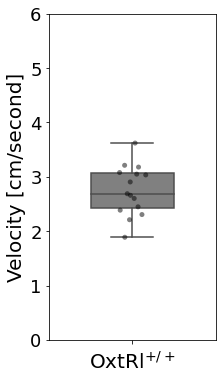

In [12]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=vel_med_df['oxtrl WT'], width = 0.5, color='grey')
bplot = sns.stripplot(y=vel_med_df['oxtrl WT'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Velocity [cm/second]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtRl^{+/+}}$', fontsize = 20)
bplot.set_ylim(0,6)
bplot.set_yticks(ticks=(0,1,2,3,4,5,6))
bplot.tick_params(labelsize = 18)

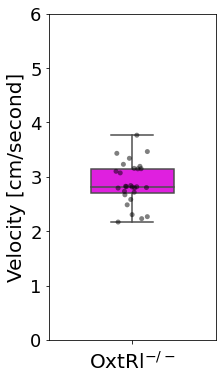

In [13]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=vel_med_df['oxtrl KO'], width = 0.5, color='magenta')
bplot = sns.stripplot(y=vel_med_df['oxtrl KO'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Velocity [cm/second]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtRl^{-/-}}$', fontsize = 20)
bplot.set_ylim(0,6)
bplot.set_yticks(ticks=(0,1,2,3,4,5,6))
bplot.tick_params(labelsize = 18)

Text(0, 0.5, 'Median velocity [cm/second]')

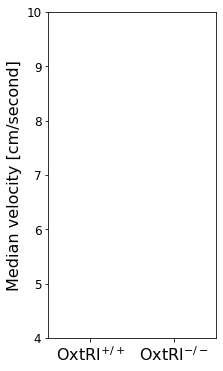

In [14]:
#vel_df.dropna(inplace=True, axis=0) # removes all NaN, required for 56dpf

fig, ax = plt.subplots(figsize = (3,6))        
plt.boxplot(vel_med_df['oxtrl KO'].transpose(), positions=[1], widths = 0.7, patch_artist=True, 
            boxprops=dict(facecolor='white',color='magenta'), whiskerprops=dict(color='magenta'), 
            capprops=dict(color='magenta'), medianprops=dict(color='magenta'), flierprops=dict(color='darkgreen'))
plt.boxplot(vel_med_df['oxtrl WT'].transpose(), positions=[0], widths = 0.7, patch_artist=True,
            boxprops=dict(facecolor='white',color='darkblue'), whiskerprops=dict(color='darkblue'), 
            capprops=dict(color='darkblue'), medianprops=dict(color='darkblue'), flierprops=dict(color='black'))



ax.set(ylim = (4,10))
plt.xticks(ticks=(0, 1), labels=('$\mathregular{OxtRl^{+/+}}$', '$\mathregular{OxtRl^{-/-}}$',), fontsize=16, 
           rotation=0)
plt.yticks(fontsize=12)
plt.ylabel('Median velocity [cm/second]', fontsize = 16)

# OxtR: Median distance over time

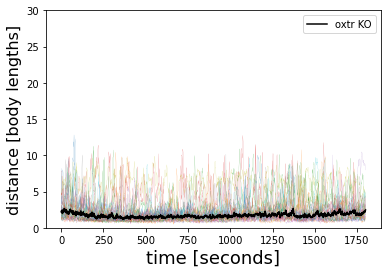

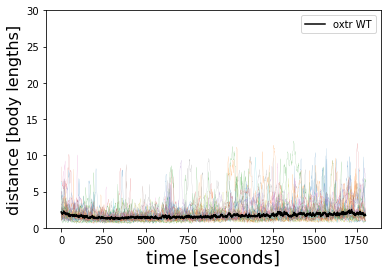

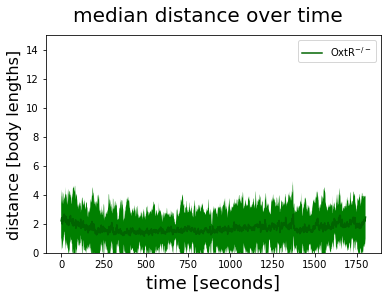

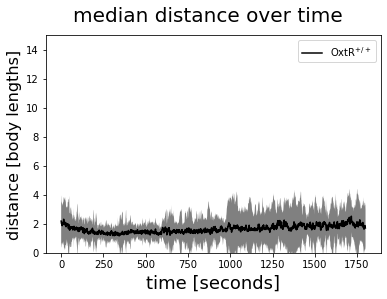

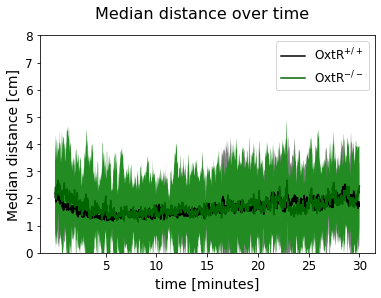

In [15]:
def plot_median(genotype):
    fig = plt.figure()
    time = np.linspace(0,1800,1800)
    plt.plot(time, dist_df[genotype], linewidth = 0.1)
    plt.plot(time, dist_df[genotype].median(axis = 1), 'k', label = genotype)
    plt.xlabel('time [seconds]', fontsize=18)
    plt.ylabel('distance [body lengths]', fontsize=16)
    plt.ylim(0, 30)
    plt.legend(loc = 'upper right')

plot_median('oxtr KO')
plot_median('oxtr WT')

fig = plt.figure()
time = np.linspace(0,1800,1800)
plt.plot(time, dist_df['oxtr KO'].median(axis = 1),'darkgreen', label='$\mathregular{OxtR^{-/-}}$')
plt.fill_between(time, dist_df['oxtr KO'].median(axis = 1) - dist_df['oxtr KO'].std(axis = 1),
         dist_df['oxtr KO'].median(axis = 1) + dist_df['oxtr KO'].std(axis = 1), fc = 'green')
fig.suptitle('median distance over time', fontsize=20)
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('distance [body lengths]', fontsize=16)
plt.ylim(0, 15)
plt.legend(loc = 'upper right')

fig = plt.figure()
time = np.linspace(0,1800,1800)
plt.plot(dist_df['oxtr WT'].median(axis = 1), 'k', label = '$\mathregular{OxtR^{+/+}}$')
plt.fill_between(time, dist_df['oxtr WT'].median(axis = 1) - dist_df['oxtr WT'].std(axis = 1),
         dist_df['oxtr WT'].median(axis = 1) + dist_df['oxtr WT'].std(axis = 1), fc = 'grey')
fig.suptitle('median distance over time', fontsize=20)
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('distance [body lengths]', fontsize=16)
plt.ylim(0, 15)
plt.legend()

fig = plt.figure()
time = np.linspace(0,1800,1800)
plt.plot(dist_df['oxtr WT'].median(axis = 1), 'k', label = '$\mathregular{OxtR^{+/+}}$')
plt.fill_between(time, dist_df['oxtr WT'].median(axis = 1) - dist_df['oxtr WT'].std(axis = 1),
         dist_df['oxtr WT'].median(axis = 1) + dist_df['oxtr WT'].std(axis = 1), fc = 'grey')
plt.plot(time, dist_df['oxtr KO'].median(axis = 1),'darkgreen', label='$\mathregular{OxtR^{-/-}}$')
plt.fill_between(time, dist_df['oxtr KO'].median(axis = 1) - dist_df['oxtr KO'].std(axis = 1),
         dist_df['oxtr KO'].median(axis = 1) + dist_df['oxtr KO'].std(axis = 1), fc = 'forestgreen')

fig.suptitle('Median distance over time', fontsize=16)
plt.xlabel('time [minutes]', fontsize=14)
plt.xticks(ticks=(300, 600, 900, 1200, 1500, 1800), labels=('5', '10', '15', '20', '25', '30'), fontsize=12, 
           rotation=0)
plt.ylabel('Median distance [cm]', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0, 8)
plt.legend(loc = 'upper right', fontsize=12)
#fig.savefig('median_distance_ILR2.png')

Text(0, 0.5, 'Median distance [cm]')

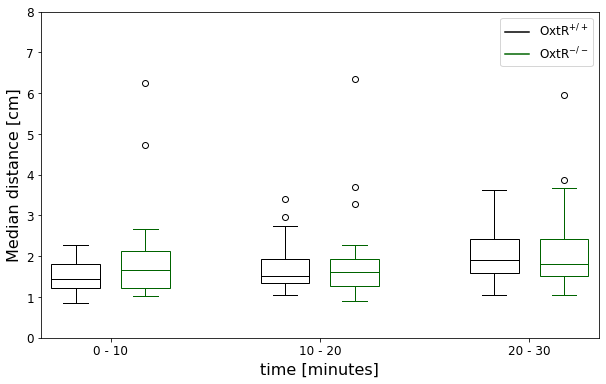

In [16]:
ind = list(range(0,len(dist_df), 600))
dist_df_minute = dist_df.iloc[0:3].copy()
for i in range(1,len(ind)):
    av = dist_df.iloc[ind[i-1]:ind[i]].median(skipna=True)
    dist_df_minute.iloc[i-1] = av
    if i == len(ind)-1:
        av = dist_df.iloc[ind[i]:].median(skipna=True)
        dist_df_minute.iloc[i] = av

fig, ax = plt.subplots(figsize = (10,6))        
plt.boxplot(dist_df_minute['oxtr KO'].transpose(), widths = 0.7, positions=[1,4,7], patch_artist=True, 
            boxprops=dict(facecolor='white',color='darkgreen'), whiskerprops=dict(color='darkgreen'), 
            capprops=dict(color='darkgreen'), medianprops=dict(color='darkgreen'), flierprops=dict(color='darkgreen'))
plt.boxplot(dist_df_minute['oxtr WT'].transpose(), widths = 0.7, positions=[0,3,6], patch_artist=True,
            boxprops=dict(facecolor='white',color='black'), whiskerprops=dict(color='black'), 
            capprops=dict(color='black'), medianprops=dict(color='black'), flierprops=dict(color='black'))

plt.plot([], c='black', label='$\mathregular{OxtR^{+/+}}$')
plt.plot([], c='darkgreen', label='$\mathregular{OxtR^{-/-}}$')
plt.legend(fontsize=12)

ax.set(ylim = (0,8))
plt.xticks(ticks=(0.5, 3.5, 6.5), labels=('0 - 10', '10 - 20', '20 - 30'), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('time [minutes]', fontsize = 16)
plt.ylabel('Median distance [cm]', fontsize = 16)

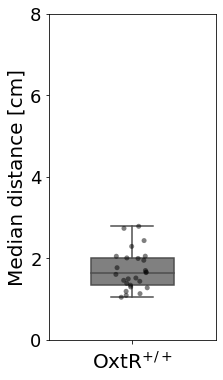

In [17]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=dist_med_df['oxtr WT'], width = 0.5, color='grey')
bplot = sns.stripplot(y=dist_med_df['oxtr WT'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Median distance [cm]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtR^{+/+}}$', fontsize = 20)
bplot.set_ylim(0,8)
bplot.set_yticks(ticks=(0,2,4,6,8))
bplot.tick_params(labelsize = 18)

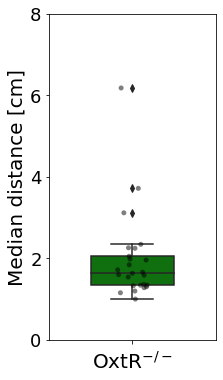

In [18]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=dist_med_df['oxtr KO'], width = 0.5, color='green')
bplot = sns.stripplot(y=dist_med_df['oxtr KO'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Median distance [cm]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtR^{-/-}}$', fontsize = 20)
bplot.set_ylim(0,8)
bplot.set_yticks(ticks=(0,2,4,6,8))
bplot.tick_params(labelsize = 18)

Text(0, 0.5, 'Median distance [cm]')

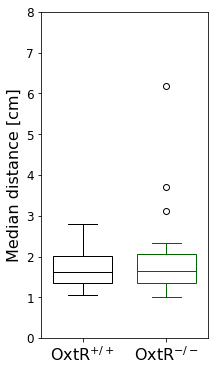

In [19]:
fig, ax = plt.subplots(figsize = (3,6))        

plt.boxplot(dist_med_df['oxtr WT'].transpose(), positions=[0], widths = 0.7, patch_artist=True,
            boxprops=dict(facecolor='white',color='black'), whiskerprops=dict(color='black'), 
            capprops=dict(color='black'), medianprops=dict(color='black'), flierprops=dict(color='black'))
plt.boxplot(dist_med_df['oxtr KO'].transpose(), positions=[1], widths = 0.7, patch_artist=True, 
            boxprops=dict(facecolor='white',color='darkgreen'), whiskerprops=dict(color='darkgreen'), 
            capprops=dict(color='darkgreen'), medianprops=dict(color='darkgreen'), flierprops=dict(color='darkgreen'))

ax.set(ylim = (0,8))
plt.xticks(ticks=(0, 1), labels=('$\mathregular{OxtR^{+/+}}$', '$\mathregular{OxtR^{-/-}}$',), fontsize=16, rotation=0)
plt.yticks(fontsize=12)
plt.ylabel('Median distance [cm]', fontsize = 16)

# OxtRl: Median distance over time

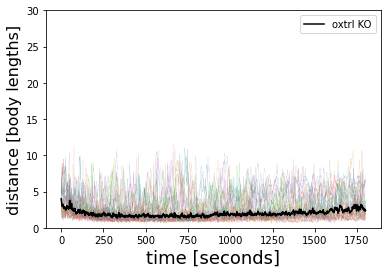

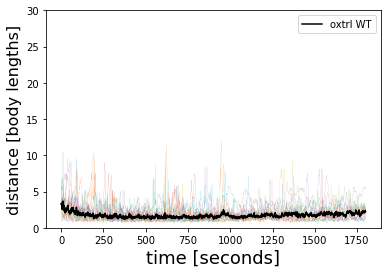

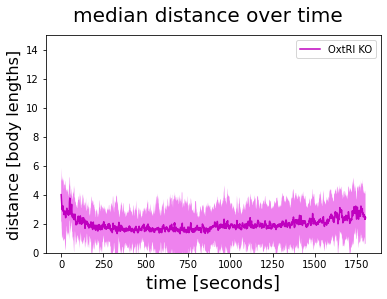

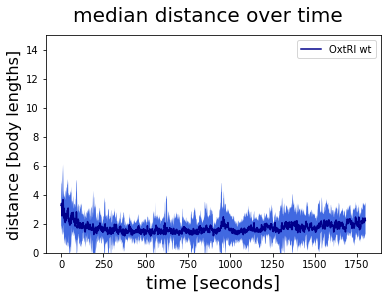

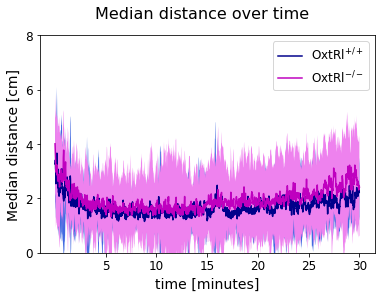

In [20]:
plot_median('oxtrl KO')
plot_median('oxtrl WT')


fig = plt.figure()
time = np.linspace(0,1800,1800)
plt.plot(time, dist_df['oxtrl KO'].median(axis = 1),'m', label='OxtRl KO')
plt.fill_between(time, dist_df['oxtrl KO'].median(axis = 1) - dist_df['oxtrl KO'].std(axis = 1),
         dist_df['oxtrl KO'].median(axis = 1) + dist_df['oxtrl KO'].std(axis = 1), fc = 'violet')
fig.suptitle('median distance over time', fontsize=20)
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('distance [body lengths]', fontsize=16)
plt.ylim(0, 15)
plt.legend()

fig = plt.figure()
time = np.linspace(0,1800,1800)
plt.plot(dist_df['oxtrl WT'].median(axis = 1), 'darkblue', label = 'OxtRl wt')
plt.fill_between(time, dist_df['oxtrl WT'].median(axis = 1) - dist_df['oxtrl WT'].std(axis = 1),
         dist_df['oxtrl WT'].median(axis = 1) + dist_df['oxtrl WT'].std(axis = 1), fc = 'royalblue')
fig.suptitle('median distance over time', fontsize=20)
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('distance [body lengths]', fontsize=16)
plt.ylim(0, 15)
plt.legend()

fig = plt.figure()
time = np.linspace(0,1800,1800)

plt.plot(dist_df['oxtrl WT'].median(axis = 1), 'darkblue', label = '$\mathregular{OxtRl^{+/+}}$')
plt.fill_between(time, dist_df['oxtrl WT'].median(axis = 1) - dist_df['oxtrl WT'].std(axis = 1),
         dist_df['oxtrl WT'].median(axis = 1) + dist_df['oxtrl WT'].std(axis = 1), fc = 'royalblue')
plt.plot(time, dist_df['oxtrl KO'].median(axis = 1),'m', label='$\mathregular{OxtRl^{-/-}}$')
plt.fill_between(time, dist_df['oxtrl KO'].median(axis = 1) - dist_df['oxtrl KO'].std(axis = 1),
         dist_df['oxtrl KO'].median(axis = 1) + dist_df['oxtrl KO'].std(axis = 1), fc = 'violet')

fig.suptitle('Median distance over time', fontsize=16)
plt.xlabel('time [minutes]', fontsize=14)
plt.xticks(ticks=(300, 600, 900, 1200, 1500, 1800), labels=('5', '10', '15', '20', '25', '30'), fontsize=12, 
           rotation=0)
plt.ylabel('Median distance [cm]', fontsize=14)
plt.yticks(ticks=(0,2,4,6,8), labels=('0', '2', '4', '6', '8'), fontsize=12, 
           rotation=0)
plt.ylim(0, 8)
plt.legend(fontsize=12)
#fig.savefig('median_distance_ILR1.png')

Text(0, 0.5, 'Median distance [cm]')

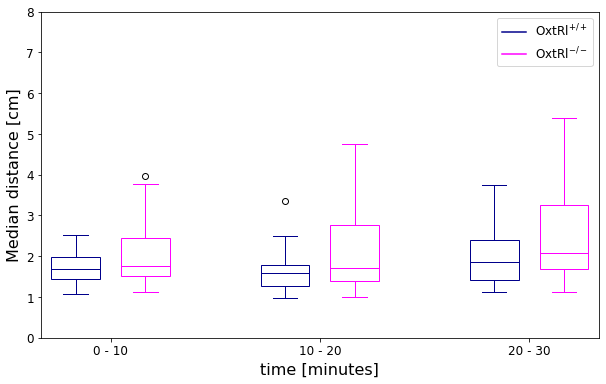

In [21]:
ind = list(range(0,len(dist_df), 600))
dist_df_minute = dist_df.iloc[0:3].copy()
for i in range(1,len(ind)):
    av = dist_df.iloc[ind[i-1]:ind[i]].median(skipna=True)
    dist_df_minute.iloc[i-1] = av
    if i == len(ind)-1:
        av = dist_df.iloc[ind[i]:].median(skipna=True)
        dist_df_minute.iloc[i] = av

fig, ax = plt.subplots(figsize = (10,6))        
plt.boxplot(dist_df_minute['oxtrl KO'].transpose(), widths = 0.7, positions=[1,4,7], patch_artist=True, 
            boxprops=dict(facecolor='white',color='magenta'), whiskerprops=dict(color='magenta'), 
            capprops=dict(color='magenta'), medianprops=dict(color='magenta'), flierprops=dict(color='darkgreen'))
plt.boxplot(dist_df_minute['oxtrl WT'].transpose(), widths = 0.7, positions=[0,3,6], patch_artist=True,
            boxprops=dict(facecolor='white',color='darkblue'), whiskerprops=dict(color='darkblue'), 
            capprops=dict(color='darkblue'), medianprops=dict(color='darkblue'), flierprops=dict(color='black'))

plt.plot([], c='darkblue', label='$\mathregular{OxtRl^{+/+}}$')
plt.plot([], c='magenta', label='$\mathregular{OxtRl^{-/-}}$')
plt.legend(fontsize=12)

ax.set(ylim = (0,8))
plt.xticks(ticks=(0.5, 3.5, 6.5), labels=('0 - 10', '10 - 20', '20 - 30'), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('time [minutes]', fontsize = 16)
plt.ylabel('Median distance [cm]', fontsize = 16)

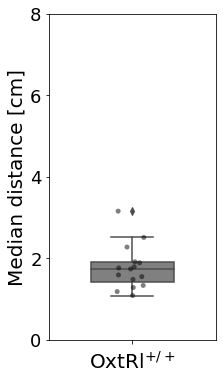

In [22]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=dist_med_df['oxtrl WT'], width = 0.5, color='grey')
bplot = sns.stripplot(y=dist_med_df['oxtrl WT'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Median distance [cm]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtRl^{+/+}}$', fontsize = 20)
bplot.set_ylim(0,8)
bplot.set_yticks(ticks=(0,2,4,6,8))
bplot.tick_params(labelsize = 18)

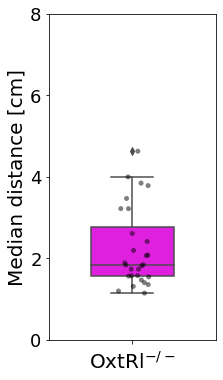

In [23]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=dist_med_df['oxtrl KO'], width = 0.5, color='magenta')
bplot = sns.stripplot(y=dist_med_df['oxtrl KO'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Median distance [cm]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtRl^{-/-}}$', fontsize = 20)
bplot.set_ylim(0,8)
bplot.set_yticks(ticks=(0,2,4,6,8))
bplot.tick_params(labelsize = 18)

Text(0, 0.5, 'Median distance [cm]')

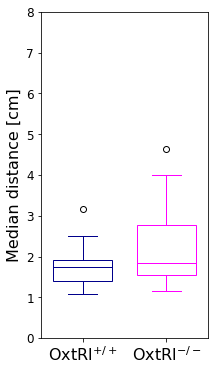

In [24]:
fig, ax = plt.subplots(figsize = (3,6))        
plt.boxplot(dist_med_df['oxtrl KO'].transpose(), positions=[1], widths = 0.7, patch_artist=True, 
            boxprops=dict(facecolor='white',color='magenta'), whiskerprops=dict(color='magenta'), 
            capprops=dict(color='magenta'), medianprops=dict(color='magenta'), flierprops=dict(color='darkgreen'))
plt.boxplot(dist_med_df['oxtrl WT'].transpose(), positions=[0], widths = 0.7, patch_artist=True,
            boxprops=dict(facecolor='white',color='darkblue'), whiskerprops=dict(color='darkblue'), 
            capprops=dict(color='darkblue'), medianprops=dict(color='darkblue'), flierprops=dict(color='black'))



ax.set(ylim = (0,8))
plt.xticks(ticks=(0, 1), labels=('$\mathregular{OxtRl^{+/+}}$', '$\mathregular{OxtRl^{-/-}}$',), fontsize=16, 
           rotation=0)
plt.yticks(fontsize=12)
plt.ylabel('Median distance [cm]', fontsize = 16)

# Overview of OxtR and OxtRl: Differences in median distance over time

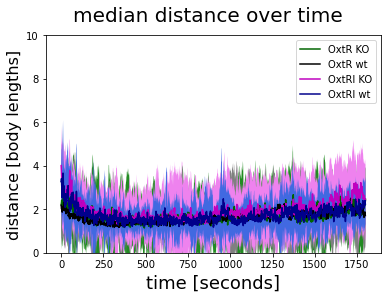

In [25]:
fig = plt.figure()
time = np.linspace(0,1800,1800)
plt.plot(time, dist_df['oxtr KO'].median(axis = 1),'darkgreen', label='OxtR KO')
plt.fill_between(time, dist_df['oxtr KO'].median(axis = 1) - dist_df['oxtr KO'].std(axis = 1),
         dist_df['oxtr KO'].median(axis = 1) + dist_df['oxtr KO'].std(axis = 1), fc = 'forestgreen')

plt.plot(dist_df['oxtr WT'].median(axis = 1), 'k', label = 'OxtR wt')
plt.fill_between(time, dist_df['oxtr WT'].median(axis = 1) - dist_df['oxtr WT'].std(axis = 1),
         dist_df['oxtr WT'].median(axis = 1) + dist_df['oxtr WT'].std(axis = 1), fc = 'grey')

plt.plot(dist_df['oxtrl KO'].median(axis = 1), 'm', label = 'OxtRl KO')
plt.fill_between(time, dist_df['oxtrl KO'].median(axis = 1) - dist_df['oxtrl KO'].std(axis = 1),
         dist_df['oxtrl KO'].median(axis = 1) + dist_df['oxtrl KO'].std(axis = 1), fc = 'violet')

plt.plot(dist_df['oxtrl WT'].median(axis = 1), 'darkblue', label = 'OxtRl wt')
plt.fill_between(time, dist_df['oxtrl WT'].median(axis = 1) - dist_df['oxtrl WT'].std(axis = 1),
         dist_df['oxtrl WT'].median(axis = 1) + dist_df['oxtrl WT'].std(axis = 1), fc = 'royalblue')

fig.suptitle('median distance over time', fontsize=20)
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('distance [body lengths]', fontsize=16)
plt.ylim(0, 10)
plt.legend()

# OxtR: Nearest neighbour distance over time

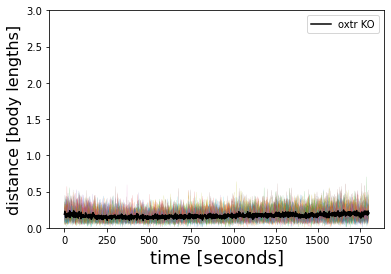

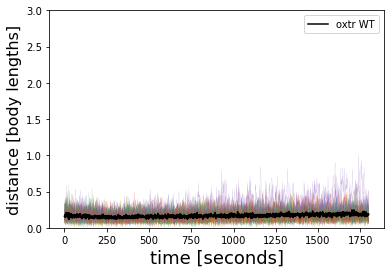

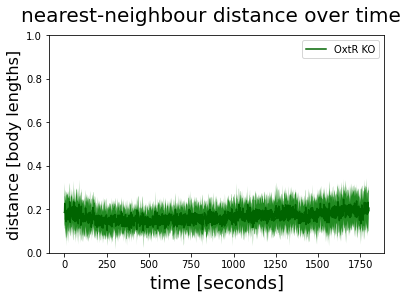

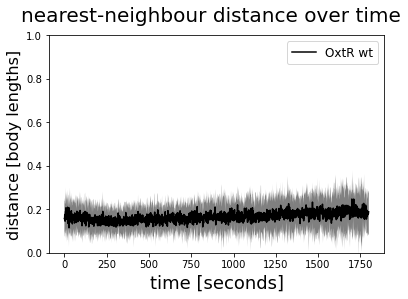

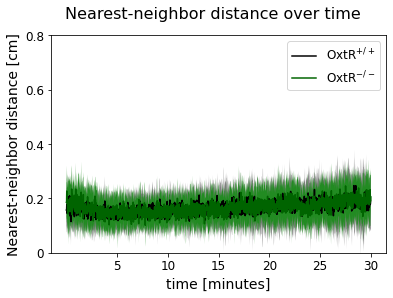

In [26]:
def plot_NN(genotype):
    fig = plt.figure()
    time = np.linspace(0,1800,1800)
    plt.plot(time, NND_df[genotype], linewidth = 0.1)
    plt.plot(time, NND_df[genotype].median(axis = 1), 'k', label = genotype)
    plt.xlabel('time [seconds]', fontsize=18)
    plt.ylabel('distance [body lengths]', fontsize=16)
    plt.ylim(0, 3)
    plt.legend(loc = 'upper right')

plot_NN('oxtr KO')
plot_NN('oxtr WT')

fig = plt.figure()
time = np.linspace(0,1800,1800)
plt.plot(time, NND_df['oxtr KO'].median(axis = 1),'darkgreen', label='OxtR KO')
plt.fill_between(time, NND_df['oxtr KO'].median(axis = 1) - NND_df['oxtr KO'].std(axis = 1),
         NND_df['oxtr KO'].median(axis = 1) + NND_df['oxtr KO'].std(axis = 1), fc = 'forestgreen')
fig.suptitle('nearest-neighbour distance over time', fontsize=20)
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('distance [body lengths]', fontsize=16)
plt.ylim(0, 1)
plt.legend()

fig = plt.figure()
time = np.linspace(0,1800,1800)
plt.plot(NND_df['oxtr WT'].median(axis = 1), 'k', label = 'OxtR wt')
plt.fill_between(time, NND_df['oxtr WT'].median(axis = 1) - NND_df['oxtr WT'].std(axis = 1),
         NND_df['oxtr WT'].median(axis = 1) + NND_df['oxtr WT'].std(axis = 1), fc = 'grey')
fig.suptitle('nearest-neighbour distance over time', fontsize=20)
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('distance [body lengths]', fontsize=16)
plt.ylim(0, 1)
plt.legend(fontsize=12)

fig = plt.figure()
time = np.linspace(0,1800,1800)

plt.plot(NND_df['oxtr WT'].median(axis = 1), 'k', label = '$\mathregular{OxtR^{+/+}}$')
plt.fill_between(time, NND_df['oxtr WT'].median(axis = 1) - NND_df['oxtr WT'].std(axis = 1),
         NND_df['oxtr WT'].median(axis = 1) + NND_df['oxtr WT'].std(axis = 1), fc = 'grey')
plt.plot(time, NND_df['oxtr KO'].median(axis = 1),'darkgreen', label= '$\mathregular{OxtR^{-/-}}$')
plt.fill_between(time, NND_df['oxtr KO'].median(axis = 1) - NND_df['oxtr KO'].std(axis = 1),
         NND_df['oxtr KO'].median(axis = 1) + NND_df['oxtr KO'].std(axis = 1), fc = 'forestgreen')

fig.suptitle('Nearest-neighbor distance over time', fontsize=16)
plt.xlabel('time [minutes]', fontsize=14)
plt.xticks(ticks=(300, 600, 900, 1200, 1500, 1800), labels=('5', '10', '15', '20', '25', '30'), fontsize=12, 
           rotation=0)
plt.ylabel('Nearest-neighbor distance [cm]', fontsize=14)
plt.ylim(0, 0.8)
plt.yticks(ticks=(0, 0.2, 0.4, 0.6, 0.8), labels=('0', '0.2', '0.4', '0.6', '0.8'), fontsize=12, 
           rotation=0)
plt.legend(fontsize=12)
#fig.savefig('nearest_neighbor_ILR2.png')

Text(0, 0.5, 'Nearest-neighbor distance [cm]')

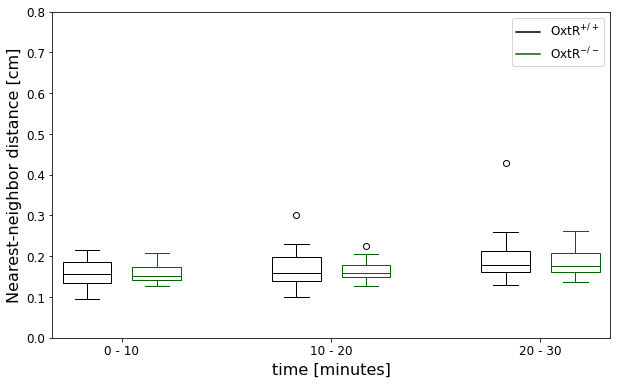

In [27]:
ind = list(range(0,len(NND_df), 600))
NND_df_minute = NND_df.iloc[0:3].copy()
for i in range(1,len(ind)):
    av = NND_df.iloc[ind[i-1]:ind[i]].median(skipna=True)
    NND_df_minute.iloc[i-1] = av
    if i == len(ind)-1:
        av = NND_df.iloc[ind[i]:].median(skipna=True)
        NND_df_minute.iloc[i] = av

fig, ax = plt.subplots(figsize = (10,6))        
plt.boxplot(NND_df_minute['oxtr KO'].transpose(), widths = 0.7, positions=[1,4,7], patch_artist=True, 
            boxprops=dict(facecolor='white',color='darkgreen'), whiskerprops=dict(color='darkgreen'), 
            capprops=dict(color='darkgreen'), medianprops=dict(color='darkgreen'), flierprops=dict(color='darkgreen'))
plt.boxplot(NND_df_minute['oxtr WT'].transpose(), widths = 0.7, positions=[0,3,6], patch_artist=True,
            boxprops=dict(facecolor='white',color='black'), whiskerprops=dict(color='black'), 
            capprops=dict(color='black'), medianprops=dict(color='black'), flierprops=dict(color='black'))

plt.plot([], c='black', label='$\mathregular{OxtR^{+/+}}$')
plt.plot([], c='darkgreen', label='$\mathregular{OxtR^{-/-}}$')
plt.legend(fontsize=12)

ax.set(ylim = (0,0.8))
plt.xticks(ticks=(0.5, 3.5, 6.5), labels=('0 - 10', '10 - 20', '20 - 30'), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('time [minutes]', fontsize = 16)
plt.ylabel('Nearest-neighbor distance [cm]', fontsize = 16)

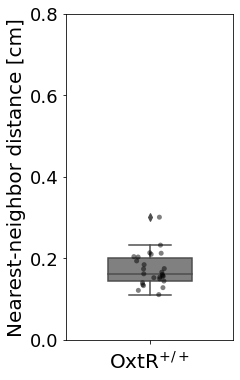

In [28]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=NND_med_df['oxtr WT'], width = 0.5, color='grey')
bplot = sns.stripplot(y=NND_med_df['oxtr WT'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Nearest-neighbor distance [cm]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtR^{+/+}}$', fontsize = 20)
bplot.set_ylim(0,0.8)
bplot.set_yticks(ticks=(0,0.2,0.4, 0.6, 0.8))
bplot.tick_params(labelsize = 18)



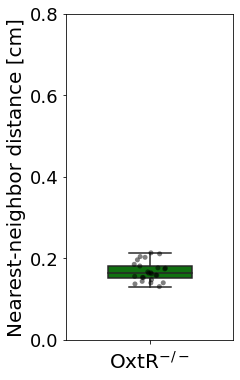

In [29]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=NND_med_df['oxtr KO'], width = 0.5, color='green')
bplot = sns.stripplot(y=NND_med_df['oxtr KO'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Nearest-neighbor distance [cm]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtR^{-/-}}$', fontsize = 20)
bplot.set_ylim(0,0.5)
bplot.set_yticks(ticks=(0,0.2,0.4,0.6,0.8))
bplot.tick_params(labelsize = 18)



Text(0, 0.5, 'Nearest-neighbor distance [cm]')

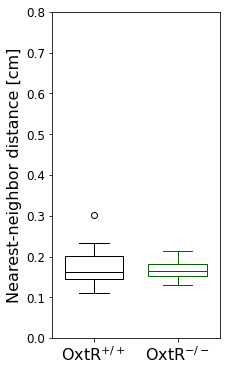

In [30]:
fig, ax = plt.subplots(figsize = (3,6))        
plt.boxplot(NND_med_df['oxtr KO'].transpose(), positions=[1], widths = 0.7, patch_artist=True, 
            boxprops=dict(facecolor='white',color='darkgreen'), whiskerprops=dict(color='darkgreen'), 
            capprops=dict(color='darkgreen'), medianprops=dict(color='darkgreen'), flierprops=dict(color='darkgreen'))
plt.boxplot(NND_med_df['oxtr WT'].transpose(), positions=[0], widths = 0.7, patch_artist=True,
            boxprops=dict(facecolor='white',color='black'), whiskerprops=dict(color='black'), 
            capprops=dict(color='black'), medianprops=dict(color='black'), flierprops=dict(color='black'))




ax.set(ylim = (0,0.8))
plt.xticks(ticks=(0, 1), labels=('$\mathregular{OxtR^{+/+}}$', '$\mathregular{OxtR^{-/-}}$',), fontsize=16, 
           rotation=0)
plt.yticks(fontsize=12)
plt.ylabel('Nearest-neighbor distance [cm]', fontsize = 16)

# OxtRl: Nearest neighbour distance over time

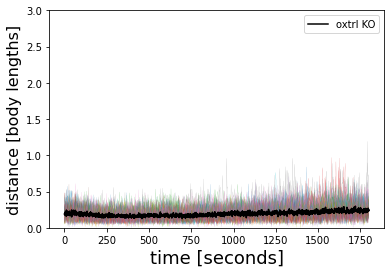

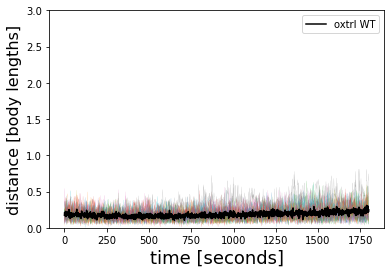

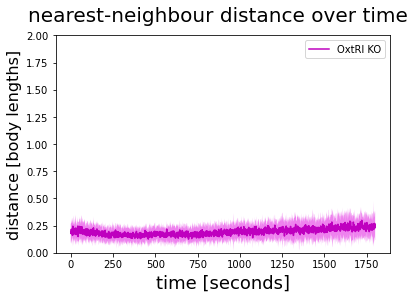

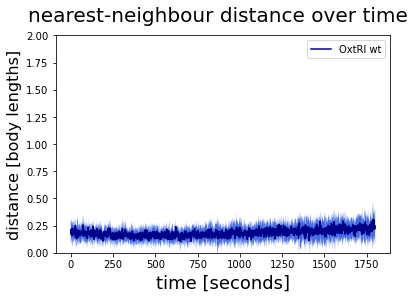

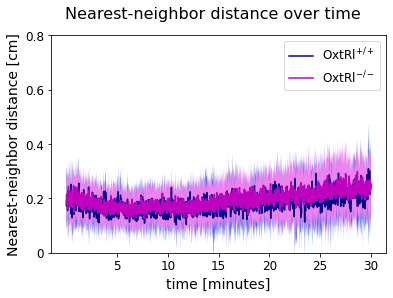

In [31]:
plot_NN('oxtrl KO')
plot_NN('oxtrl WT')

fig = plt.figure()
time = np.linspace(0,1800,1800)
plt.plot(time, NND_df['oxtrl KO'].median(axis = 1),'m', label='OxtRl KO')
plt.fill_between(time, NND_df['oxtrl KO'].median(axis = 1) - NND_df['oxtrl KO'].std(axis = 1),
         NND_df['oxtrl KO'].median(axis = 1) + NND_df['oxtrl KO'].std(axis = 1), fc = 'violet')
fig.suptitle('nearest-neighbour distance over time', fontsize=20)
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('distance [body lengths]', fontsize=16)
plt.ylim(0, 2)
plt.legend()

fig = plt.figure()
time = np.linspace(0,1800,1800)
plt.plot(NND_df['oxtrl WT'].median(axis = 1), 'darkblue', label = 'OxtRl wt')
plt.fill_between(time, NND_df['oxtrl WT'].median(axis = 1) - NND_df['oxtrl WT'].std(axis = 1),
         NND_df['oxtrl WT'].median(axis = 1) + NND_df['oxtrl WT'].std(axis = 1), fc = 'royalblue')
fig.suptitle('nearest-neighbour distance over time', fontsize=20)
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('distance [body lengths]', fontsize=16)
plt.ylim(0, 2)
plt.legend()

fig = plt.figure()
time = np.linspace(0,1800,1800)

plt.plot(NND_df['oxtrl WT'].median(axis = 1), 'darkblue', label = '$\mathregular{OxtRl^{+/+}}$')
plt.fill_between(time, NND_df['oxtrl WT'].median(axis = 1) - NND_df['oxtrl WT'].std(axis = 1),
         NND_df['oxtrl WT'].median(axis = 1) + NND_df['oxtrl WT'].std(axis = 1), fc = 'royalblue')
plt.plot(time, NND_df['oxtrl KO'].median(axis = 1),'m', label='$\mathregular{OxtRl^{-/-}}$')
plt.fill_between(time, NND_df['oxtrl KO'].median(axis = 1) - NND_df['oxtrl KO'].std(axis = 1),
         NND_df['oxtrl KO'].median(axis = 1) + NND_df['oxtrl KO'].std(axis = 1), fc = 'violet')

fig.suptitle('Nearest-neighbor distance over time', fontsize=16)
plt.xlabel('time [minutes]', fontsize=14)
plt.xticks(ticks=(300, 600, 900, 1200, 1500, 1800), labels=('5', '10', '15', '20', '25', '30'), fontsize=12, 
           rotation=0)
plt.ylabel('Nearest-neighbor distance [cm]', fontsize=14)
plt.ylim(0, 0.8)
plt.yticks(ticks=(0, 0.2, 0.4, 0.6, 0.8), labels=('0', '0.2', '0.4', '0.6', '0.8'), fontsize=12, 
           rotation=0)
plt.legend(fontsize=12)
#fig.savefig('nearest_neighbor_ILR1.png')

Text(0, 0.5, 'Nearest-neighbor distance [cm]')

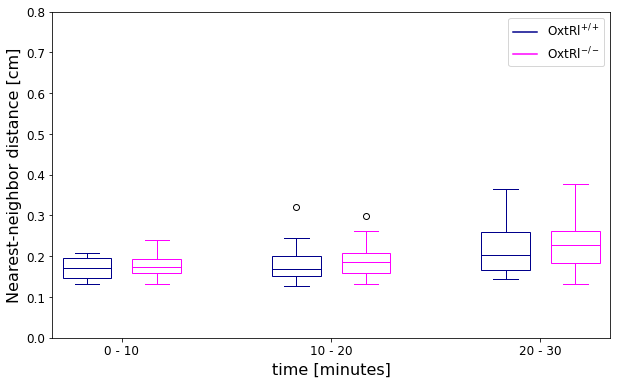

In [32]:
ind = list(range(0,len(NND_df), 600))
NND_df_minute = NND_df.iloc[0:3].copy()
for i in range(1,len(ind)):
    av = NND_df.iloc[ind[i-1]:ind[i]].median(skipna=True)
    NND_df_minute.iloc[i-1] = av
    if i == len(ind)-1:
        av = NND_df.iloc[ind[i]:].median(skipna=True)
        NND_df_minute.iloc[i] = av

fig, ax = plt.subplots(figsize = (10,6))

plt.boxplot(NND_df_minute['oxtrl WT'].transpose(), widths = 0.7, positions=[0,3,6], patch_artist=True,
            boxprops=dict(facecolor='white',color='darkblue'), whiskerprops=dict(color='darkblue'), 
            capprops=dict(color='darkblue'), medianprops=dict(color='darkblue'), flierprops=dict(color='black'))
plt.boxplot(NND_df_minute['oxtrl KO'].transpose(), widths = 0.7, positions=[1,4,7], patch_artist=True, 
            boxprops=dict(facecolor='white',color='magenta'), whiskerprops=dict(color='magenta'), 
            capprops=dict(color='magenta'), medianprops=dict(color='magenta'), flierprops=dict(color='darkgreen'))

plt.plot([], c='darkblue', label='$\mathregular{OxtRl^{+/+}}$')
plt.plot([], c='magenta', label='$\mathregular{OxtRl^{-/-}}$')
plt.legend(fontsize=12)

ax.set(ylim = (0,0.8))
plt.xticks(ticks=(0.5, 3.5, 6.5), labels=('0 - 10', '10 - 20', '20 - 30'), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('time [minutes]', fontsize = 16)
plt.ylabel('Nearest-neighbor distance [cm]', fontsize = 16)

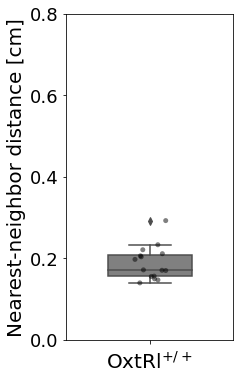

In [33]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=NND_med_df['oxtrl WT'], width = 0.5, color='grey')
bplot = sns.stripplot(y=NND_med_df['oxtrl WT'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Nearest-neighbor distance [cm]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtRl^{+/+}}$', fontsize = 20)
bplot.set_ylim(0,0.8)
bplot.set_yticks(ticks=(0,0.2,0.4,0.6,0.8))
bplot.tick_params(labelsize = 18)

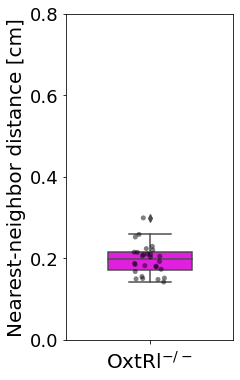

In [34]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=NND_med_df['oxtrl KO'], width = 0.5, color='magenta')
bplot = sns.stripplot(y=NND_med_df['oxtrl KO'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Nearest-neighbor distance [cm]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtRl^{-/-}}$', fontsize = 20)
bplot.set_ylim(0,0.8)
bplot.set_yticks(ticks=(0,0.2,0.4,0.6,0.8))
bplot.tick_params(labelsize = 18)


Text(0, 0.5, 'Nearest-neighbor distance [cm]')

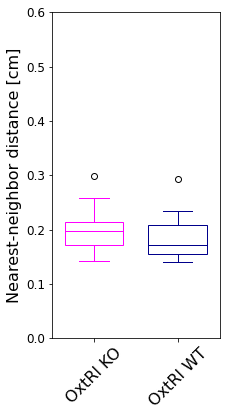

In [35]:
fig, ax = plt.subplots(figsize = (3,6))        
plt.boxplot(NND_med_df['oxtrl KO'].transpose(), positions=[0], widths = 0.7, patch_artist=True, 
            boxprops=dict(facecolor='white',color='magenta'), whiskerprops=dict(color='magenta'), 
            capprops=dict(color='magenta'), medianprops=dict(color='magenta'), flierprops=dict(color='darkgreen'))
plt.boxplot(NND_med_df['oxtrl WT'].transpose(), positions=[1], widths = 0.7, patch_artist=True,
            boxprops=dict(facecolor='white',color='darkblue'), whiskerprops=dict(color='darkblue'), 
            capprops=dict(color='darkblue'), medianprops=dict(color='darkblue'), flierprops=dict(color='black'))



ax.set(ylim = (0,0.6))
plt.xticks(ticks=(0, 1), labels=('OxtRl KO', 'OxtRl WT',), fontsize=16, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Nearest-neighbor distance [cm]', fontsize = 16)

# Overview of OxtR and OxtRl: Nearest neighbour distance over time

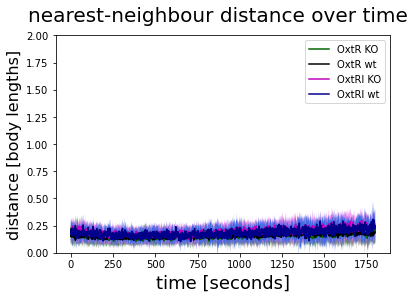

In [36]:
fig = plt.figure()
time = np.linspace(0,1800,1800)
plt.plot(time, NND_df['oxtr KO'].median(axis = 1),'darkgreen', label='OxtR KO')
plt.fill_between(time, NND_df['oxtr KO'].median(axis = 1) - NND_df['oxtr KO'].std(axis = 1),
         NND_df['oxtr KO'].median(axis = 1) + NND_df['oxtr KO'].std(axis = 1), fc = 'forestgreen')

plt.plot(NND_df['oxtr WT'].median(axis = 1), 'k', label = 'OxtR wt')
plt.fill_between(time, NND_df['oxtr WT'].median(axis = 1) - NND_df['oxtr WT'].std(axis = 1),
         NND_df['oxtr WT'].median(axis = 1) + NND_df['oxtr WT'].std(axis = 1), fc = 'grey')

plt.plot(NND_df['oxtrl KO'].median(axis = 1), 'm', label = 'OxtRl KO')
plt.fill_between(time, NND_df['oxtrl KO'].median(axis = 1) - NND_df['oxtrl KO'].std(axis = 1),
         NND_df['oxtrl KO'].median(axis = 1) + NND_df['oxtrl KO'].std(axis = 1), fc = 'violet')

plt.plot(NND_df['oxtrl WT'].median(axis = 1), 'darkblue', label = 'OxtRl wt')
plt.fill_between(time, NND_df['oxtrl WT'].median(axis = 1) - NND_df['oxtrl WT'].std(axis = 1),
         NND_df['oxtrl WT'].median(axis = 1) + NND_df['oxtrl WT'].std(axis = 1), fc = 'royalblue')

fig.suptitle('nearest-neighbour distance over time', fontsize=20)
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('distance [body lengths]', fontsize=16)
plt.ylim(0, 2)
plt.legend(loc = 'upper right')

# OxtR: Farthest neighbour distance over time

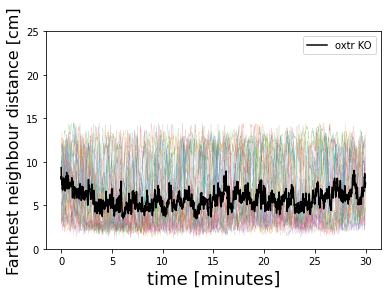

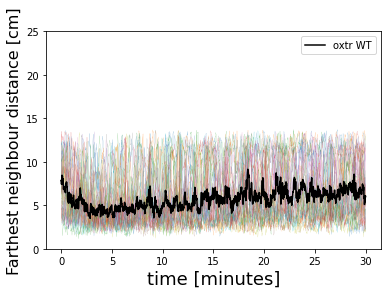

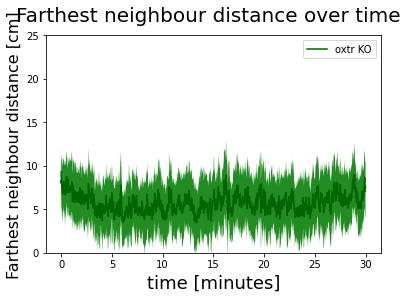

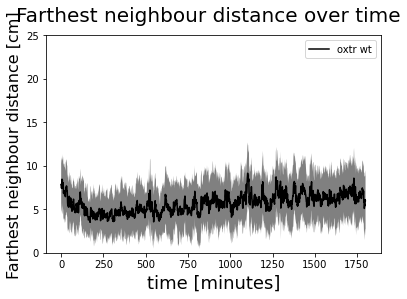

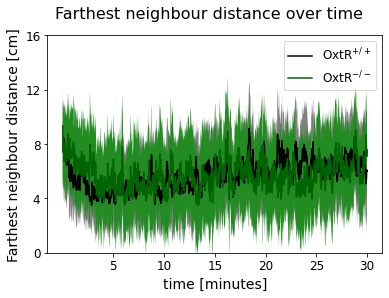

In [37]:
def plot_FD(genotype):
    fig = plt.figure()
    time = np.linspace(0,30,1800)
    plt.plot(time, FD_df[genotype], linewidth = 0.1)
    plt.plot(time, FD_df[genotype].median(axis = 1), 'k', label = genotype)
    plt.xlabel('time [minutes]', fontsize=18)
    plt.ylabel('Farthest neighbour distance [cm]', fontsize=16)
    plt.ylim(0, 25)
    plt.legend(loc = 'upper right')

plot_FD('oxtr KO')
plot_FD('oxtr WT')

fig = plt.figure()
time = np.linspace(0,30,1800)
plt.plot(time, FD_df['oxtr KO'].median(axis = 1),'darkgreen', label='oxtr KO')
plt.fill_between(time, FD_df['oxtr KO'].median(axis = 1) - FD_df['oxtr KO'].std(axis = 1),
         FD_df['oxtr KO'].median(axis = 1) + FD_df['oxtr KO'].std(axis = 1), fc = 'forestgreen')
fig.suptitle('Farthest neighbour distance over time', fontsize=20)
plt.xlabel('time [minutes]', fontsize=18)
plt.ylabel('Farthest neighbour distance [cm]', fontsize=16)
plt.ylim(0, 25)
plt.legend()

fig = plt.figure()
time = np.linspace(0,1800,1800)
plt.plot(FD_df['oxtr WT'].median(axis = 1), 'black', label = 'oxtr wt')
plt.fill_between(time, FD_df['oxtr WT'].median(axis = 1) - FD_df['oxtr WT'].std(axis = 1),
         FD_df['oxtr WT'].median(axis = 1) + FD_df['oxtr WT'].std(axis = 1), fc = 'grey')
fig.suptitle('Farthest neighbour distance over time', fontsize=20)
plt.xlabel('time [minutes]', fontsize=18)
plt.ylabel('Farthest neighbour distance [cm]', fontsize=16)
plt.ylim(0, 25)
plt.legend()

fig = plt.figure()
time = np.linspace(0,1800,1800)

plt.plot(FD_df['oxtr WT'].median(axis = 1), 'black', label = '$\mathregular{OxtR^{+/+}}$')
plt.fill_between(time, FD_df['oxtr WT'].median(axis = 1) - FD_df['oxtr WT'].std(axis = 1),
         FD_df['oxtr WT'].median(axis = 1) + FD_df['oxtr WT'].std(axis = 1), fc = 'grey')
plt.plot(time, FD_df['oxtr KO'].median(axis = 1),'darkgreen', label='$\mathregular{OxtR^{-/-}}$')
plt.fill_between(time, FD_df['oxtr KO'].median(axis = 1) - FD_df['oxtr KO'].std(axis = 1),
         FD_df['oxtr KO'].median(axis = 1) + FD_df['oxtr KO'].std(axis = 1), fc = 'forestgreen')

fig.suptitle('Farthest neighbour distance over time', fontsize=16)
plt.xlabel('time [minutes]', fontsize=14)
plt.xticks(ticks=(300, 600, 900, 1200, 1500, 1800), labels=('5', '10', '15', '20', '25', '30'), fontsize=12, 
           rotation=0)
plt.ylabel('Farthest neighbour distance [cm]', fontsize=14)
plt.ylim(0, 16)
plt.yticks(ticks=(0, 4, 8, 12, 16), labels=('0', '4', '8', '12', '16'), fontsize=12, 
           rotation=0)
plt.legend(fontsize=12)
#fig.savefig('nearest_neighbor_ILR1.png')

Text(0, 0.5, 'Farthest-neighbor distance [cm]')

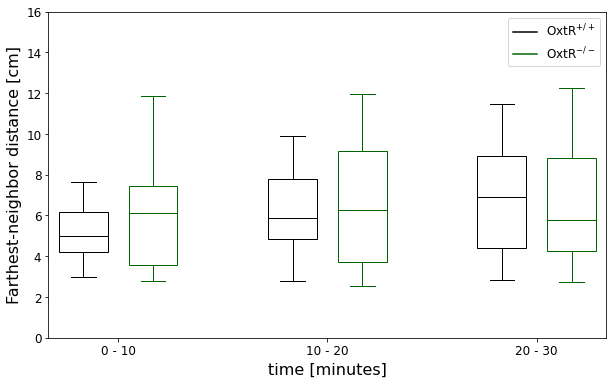

In [38]:
ind = list(range(0,len(FD_df), 600))
FD_df_minute = FD_df.iloc[0:3].copy()
for i in range(1,len(ind)):
    av = FD_df.iloc[ind[i-1]:ind[i]].median(skipna=True)
    FD_df_minute.iloc[i-1] = av
    if i == len(ind)-1:
        av = FD_df.iloc[ind[i]:].median(skipna=True)
        FD_df_minute.iloc[i] = av

fig, ax = plt.subplots(figsize = (10,6))        
plt.boxplot(FD_df_minute['oxtr KO'].transpose(), widths = 0.7, positions=[1,4,7], patch_artist=True, 
            boxprops=dict(facecolor='white',color='darkgreen'), whiskerprops=dict(color='darkgreen'), 
            capprops=dict(color='darkgreen'), medianprops=dict(color='darkgreen'), flierprops=dict(color='darkgreen'))
plt.boxplot(FD_df_minute['oxtr WT'].transpose(), widths = 0.7, positions=[0,3,6], patch_artist=True,
            boxprops=dict(facecolor='white',color='black'), whiskerprops=dict(color='black'), 
            capprops=dict(color='black'), medianprops=dict(color='black'), flierprops=dict(color='black'))

plt.plot([], c='black', label='$\mathregular{OxtR^{+/+}}$')
plt.plot([], c='darkgreen', label='$\mathregular{OxtR^{-/-}}$')
plt.legend(fontsize=12)

ax.set(ylim = (0,16))
plt.xticks(ticks=(0.5, 3.5, 6.5), labels=('0 - 10', '10 - 20', '20 - 30'), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('time [minutes]', fontsize = 16)
plt.ylabel('Farthest-neighbor distance [cm]', fontsize = 16)

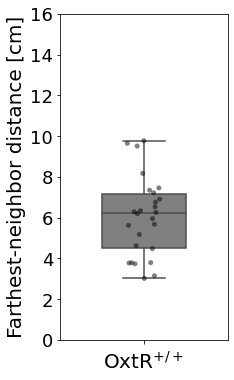

In [39]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=FD_med_df['oxtr WT'], width = 0.5, color='grey')
bplot = sns.stripplot(y=FD_med_df['oxtr WT'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Farthest-neighbor distance [cm]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtR^{+/+}}$', fontsize = 20)
bplot.set_ylim(0,16)
bplot.set_yticks(ticks=(0,2,4,6,8,10,12,14,16))
bplot.tick_params(labelsize = 18)

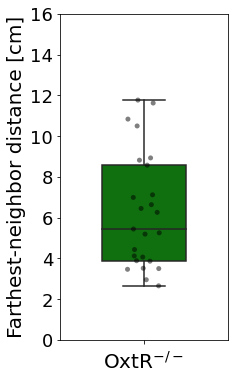

In [40]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=FD_med_df['oxtr KO'], width = 0.5, color='green')
bplot = sns.stripplot(y=FD_med_df['oxtr KO'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Farthest-neighbor distance [cm]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtR^{-/-}}$', fontsize = 20)
bplot.set_ylim(0,16)
bplot.set_yticks(ticks=(0,2,4,6,8,10,12,14,16))
bplot.tick_params(labelsize = 18)

Text(0, 0.5, 'Farthest-neighbor distance [cm]')

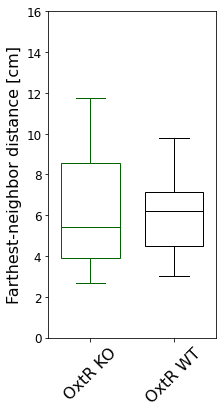

In [41]:
fig, ax = plt.subplots(figsize = (3,6))        
plt.boxplot(FD_med_df['oxtr KO'].transpose(), positions=[0], widths = 0.7, patch_artist=True, 
            boxprops=dict(facecolor='white',color='darkgreen'), whiskerprops=dict(color='darkgreen'), 
            capprops=dict(color='darkgreen'), medianprops=dict(color='darkgreen'), flierprops=dict(color='darkgreen'))
plt.boxplot(FD_med_df['oxtr WT'].transpose(), positions=[1], widths = 0.7, patch_artist=True,
            boxprops=dict(facecolor='white',color='black'), whiskerprops=dict(color='black'), 
            capprops=dict(color='black'), medianprops=dict(color='black'), flierprops=dict(color='black'))



ax.set(ylim = (0,16))
plt.xticks(ticks=(0, 1), labels=('OxtR KO', 'OxtR WT',), fontsize=16, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Farthest-neighbor distance [cm]', fontsize = 16)

# OxtRl: Farthest neighbour distance over time

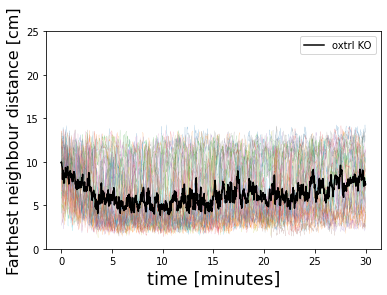

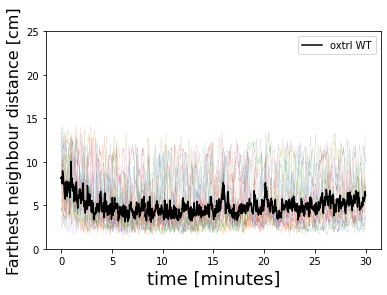

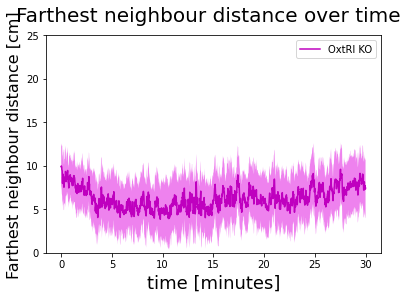

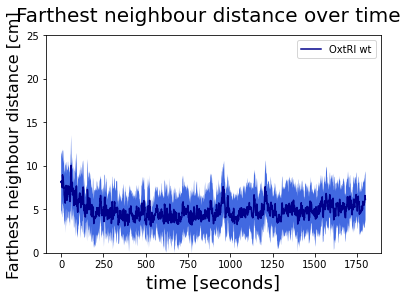

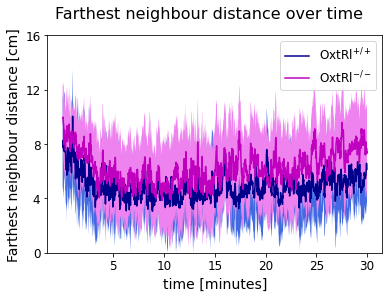

In [42]:
plot_FD('oxtrl KO')
plot_FD('oxtrl WT')

fig = plt.figure()
time = np.linspace(0,30,1800)
plt.plot(time, FD_df['oxtrl KO'].median(axis = 1),'m', label='OxtRl KO')
plt.fill_between(time, FD_df['oxtrl KO'].median(axis = 1) - FD_df['oxtrl KO'].std(axis = 1),
         FD_df['oxtrl KO'].median(axis = 1) + FD_df['oxtrl KO'].std(axis = 1), fc = 'violet')
fig.suptitle('Farthest neighbour distance over time', fontsize=20)
plt.xlabel('time [minutes]', fontsize=18)
plt.ylabel('Farthest neighbour distance [cm]', fontsize=16)
plt.ylim(0, 25)
plt.legend()

fig = plt.figure()
time = np.linspace(0,1800,1800)
plt.plot(FD_df['oxtrl WT'].median(axis = 1), 'darkblue', label = 'OxtRl wt')
plt.fill_between(time, FD_df['oxtrl WT'].median(axis = 1) - FD_df['oxtrl WT'].std(axis = 1),
         FD_df['oxtrl WT'].median(axis = 1) + FD_df['oxtrl WT'].std(axis = 1), fc = 'royalblue')
fig.suptitle('Farthest neighbour distance over time', fontsize=20)
plt.xlabel('time [seconds]', fontsize=18)
plt.ylabel('Farthest neighbour distance [cm]', fontsize=16)
plt.ylim(0, 25)
plt.legend()

fig = plt.figure()
time = np.linspace(0,1800,1800)

plt.plot(FD_df['oxtrl WT'].median(axis = 1), 'darkblue', label = '$\mathregular{OxtRl^{+/+}}$')
plt.fill_between(time, FD_df['oxtrl WT'].median(axis = 1) - FD_df['oxtrl WT'].std(axis = 1),
         FD_df['oxtrl WT'].median(axis = 1) + FD_df['oxtrl WT'].std(axis = 1), fc = 'royalblue')
plt.plot(time, FD_df['oxtrl KO'].median(axis = 1),'m', label='$\mathregular{OxtRl^{-/-}}$')
plt.fill_between(time, FD_df['oxtrl KO'].median(axis = 1) - FD_df['oxtrl KO'].std(axis = 1),
         FD_df['oxtrl KO'].median(axis = 1) + FD_df['oxtrl KO'].std(axis = 1), fc = 'violet')

fig.suptitle('Farthest neighbour distance over time', fontsize=16)
plt.xlabel('time [minutes]', fontsize=14)
plt.xticks(ticks=(300, 600, 900, 1200, 1500, 1800), labels=('5', '10', '15', '20', '25', '30'), fontsize=12, 
           rotation=0)
plt.ylabel('Farthest neighbour distance [cm]', fontsize=14)
plt.ylim(0, 16)
plt.yticks(ticks=(0, 4, 8, 12, 16), labels=('0', '4', '8', '12', '16'), fontsize=12, 
           rotation=0)
plt.legend(fontsize=12)
#fig.savefig('nearest_neighbor_ILR1.png')

Text(0, 0.5, 'Farthest-neighbor distance [cm]')

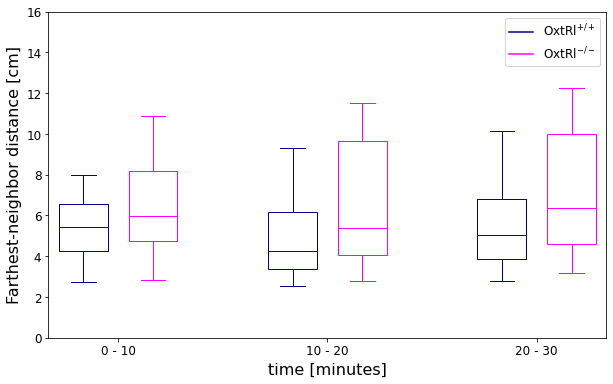

In [43]:
ind = list(range(0,len(FD_df), 600))
FD_df_minute = FD_df.iloc[0:3].copy()
for i in range(1,len(ind)):
    av = FD_df.iloc[ind[i-1]:ind[i]].median(skipna=True)
    FD_df_minute.iloc[i-1] = av
    if i == len(ind)-1:
        av = FD_df.iloc[ind[i]:].median(skipna=True)
        FD_df_minute.iloc[i] = av

fig, ax = plt.subplots(figsize = (10,6))        
plt.boxplot(FD_df_minute['oxtrl KO'].transpose(), widths = 0.7, positions=[1,4,7], patch_artist=True, 
            boxprops=dict(facecolor='white',color='magenta'), whiskerprops=dict(color='magenta'), 
            capprops=dict(color='magenta'), medianprops=dict(color='magenta'), flierprops=dict(color='darkgreen'))
plt.boxplot(FD_df_minute['oxtrl WT'].transpose(), widths = 0.7, positions=[0,3,6], patch_artist=True,
            boxprops=dict(facecolor='white',color='darkblue'), whiskerprops=dict(color='darkblue'), 
            capprops=dict(color='darkblue'), medianprops=dict(color='darkblue'), flierprops=dict(color='black'))


plt.plot([], c='darkblue', label='$\mathregular{OxtRl^{+/+}}$')
plt.plot([], c='magenta', label='$\mathregular{OxtRl^{-/-}}$')
plt.legend(fontsize=12)

ax.set(ylim = (0,16))
plt.xticks(ticks=(0.5, 3.5, 6.5), labels=('0 - 10', '10 - 20', '20 - 30'), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('time [minutes]', fontsize = 16)
plt.ylabel('Farthest-neighbor distance [cm]', fontsize = 16)

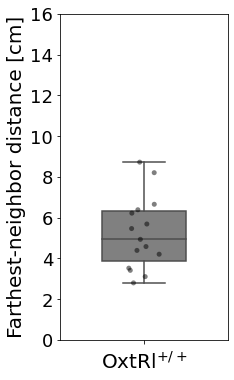

In [44]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=FD_med_df['oxtrl WT'], width = 0.5, color='grey')
bplot = sns.stripplot(y=FD_med_df['oxtrl WT'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Farthest-neighbor distance [cm]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtRl^{+/+}}$', fontsize = 20)
bplot.set_ylim(0,16)
bplot.set_yticks(ticks=(0,2,4,6,8,10,12,14,16))
bplot.tick_params(labelsize = 18)

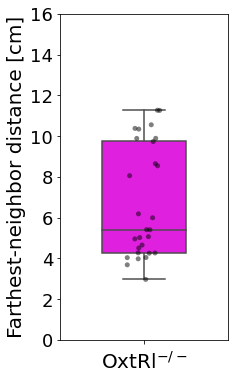

In [45]:
fig, ax = plt.subplots(figsize = (3,6)) 
bplot = sns.boxplot(y=FD_med_df['oxtrl KO'], width = 0.5, color='magenta')
bplot = sns.stripplot(y=FD_med_df['oxtrl KO'], jitter=True, marker='o', alpha=0.5,color='0', edgecolor='0')
bplot.set_ylabel('Farthest-neighbor distance [cm]', fontsize=20)
bplot.set_xlabel('$\mathregular{OxtRl^{-/-}}$', fontsize = 20)
bplot.set_ylim(0,16)
bplot.set_yticks(ticks=(0,2,4,6,8,10,12,14,16))
bplot.tick_params(labelsize = 18)

Text(0, 0.5, 'Farthest-neighbor distance [cm]')

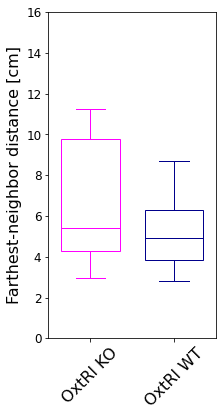

In [46]:
fig, ax = plt.subplots(figsize = (3,6))        
plt.boxplot(FD_med_df['oxtrl KO'], positions=[0], widths = 0.7, patch_artist=True, 
            boxprops=dict(facecolor='white',color='magenta'), whiskerprops=dict(color='magenta'), 
            capprops=dict(color='magenta'), medianprops=dict(color='magenta'), flierprops=dict(color='darkgreen'))
plt.boxplot(FD_med_df['oxtrl WT'], positions=[1], widths = 0.7, patch_artist=True,
            boxprops=dict(facecolor='white',color='darkblue'), whiskerprops=dict(color='darkblue'), 
            capprops=dict(color='darkblue'), medianprops=dict(color='darkblue'), flierprops=dict(color='black'))



ax.set(ylim = (0,16))
plt.xticks(ticks=(0, 1), labels=('OxtRl KO', 'OxtRl WT',), fontsize=16, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Farthest-neighbor distance [cm]', fontsize = 16)

# Statistical analysis

In [47]:
np.shape((dist_med_df['oxtrl KO']))

(28,)

In [86]:
# iloc[0]=erster bin, iloc[1]=zweiter bin
#mannwhitneyu(dist_med_df['oxtr KO'], dist_med_df['oxtr WT'], use_continuity=True, alternative=None)
#mannwhitneyu(FD_df_minute['oxtrl KO'].iloc[0], FD_df_minute['oxtrl WT'].iloc[0], use_continuity=True, alternative=None)
 
kruskal(NND_med_df['oxtr KO'], NND_med_df['oxtr WT'], NND_med_df['oxtrl KO'], NND_med_df['oxtrl WT'], nan_policy='omit')
# kstest(FD_med_df['oxtr KO'], 'norm')
# ranksums(NND_med_df['oxtr KO'], NND_med_df['oxtr WT'])

KruskalResult(statistic=10.201048595301643, pvalue=0.01693222997722401)

In [49]:
# Save as csv
#vel_df.to_csv('vel_df.csv')
#NND_df.to_csv('NND_df.csv')
#dist_df.to_csv('dist_df.csv')
#FD_df.to_csv('FD_df.csv')

In [50]:
# tracking reliability


In [51]:
# example trajectories


In [52]:
# shoaling vs schooling